# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [31]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) #noise
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [32]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.8036,  0.4722]) 
label: tensor([-1.0182])


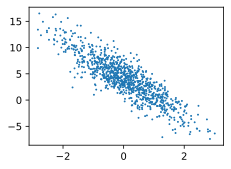

In [33]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [34]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.4149,  0.0085],
        [-0.0155, -1.4818],
        [-0.0213, -0.0710],
        [-0.5304,  1.0634],
        [-0.5046,  0.5059],
        [-0.7205, -0.6533],
        [-1.4751,  0.8857],
        [-0.2375, -0.1481],
        [ 0.7593, -1.0741],
        [ 0.0429, -0.4908]]) 
 tensor([[ 3.3391],
        [ 9.1958],
        [ 4.3948],
        [-0.4781],
        [ 1.4735],
        [ 4.9874],
        [-1.7534],
        [ 4.2216],
        [ 9.3696],
        [ 5.9396]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [35]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型，将模型的输入和参数同模型的输出关联起来

In [36]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [37]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [38]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [39]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.044101
epoch 2, loss 0.000172
epoch 3, loss 0.000052


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [40]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0007, -0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([2.8610e-06], grad_fn=<RsubBackward1>)
